Tensorflow CNN Source = https://www.tensorflow.org/tutorials/images/cnn

---



In [6]:
%pip install tensorflow

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [7]:
import os

base_dir = './book_chair_laptop_dataset'


In [8]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import json
import numpy as np
from collections import defaultdict
from tensorflow.keras.utils import load_img, img_to_array


# Used AI (ChatGPT 5) to help format data correclty in order to match data in tensorflow documentation

# create a label map so each class name is tied to a number
# this is what the model will learn to predict later
label_map_all = {'book': 0, 'chair': 1, 'laptop': 2}

# turns the keys (class names) into a set so we can check faster if something is in our target classes
target_classes = set(label_map_all.keys())

# lists that will hold all of our image data and their labels
images, labels = [], []

# function to handle one image at a time
# it finds the dominant object in the image (the one that takes up the most area)
# then loads that image and adds both the image and its label to our lists
def process_one_image(img_path, anns, id2name):
    # keep track of how much area each object class takes up in the image
    area_by_class = defaultdict(float)
    for ann in anns:
        name = id2name.get(ann["category_id"]) # get the class name for this annotation
        if name in target_classes:
            area_by_class[name] += float(ann.get("area", 0.0)) # add its area to that class total

    # skip this image if it doesn't contain any of our target classes
    if not area_by_class:
        return False

    # pick the class with the largest total area (dominant class)
    chosen_name = max(area_by_class.items(), key=lambda kv: kv[1])[0]
    y_raw = label_map_all[chosen_name] # get the label id for that class

    # load and resize the image to 180x180 pixels and scale pixel values between 0 and 1
    img = load_img(img_path, target_size=(180, 180))
    img = img_to_array(img) / 255.0

    # save image and label so we can use them later for training
    images.append(img)
    labels.append(y_raw)
    return True

# loop through everything in our base folder and look for .json files
for fname in os.listdir(base_dir):
    if not fname.endswith(".json"):
        continue # skip anything that isn't a JSON file

    fpath = os.path.join(base_dir, fname)
    with open(fpath, "r") as f:
        data = json.load(f)

    # --- CASE A: combined COCO-style file (one JSON describing all images) ---
    if all(k in data for k in ("images", "annotations", "categories")):
        # link category ids to their names (like 56 -> 'chair')
        id2name = {c["id"]: c["name"] for c in data["categories"]}

        # group all annotations by image_id (so we can process each image easily)
        anns_by_img = defaultdict(list)
        for ann in data["annotations"]:
            anns_by_img[ann["image_id"]].append(ann)

        # now loop through every image described in the JSON
        for img_info in data["images"]:
            img_name = img_info["file_name"]
            img_path = os.path.join(base_dir, img_name)

            # skip if the image doesn't actually exist
            if not os.path.exists(img_path):
                continue

            # process this image and its annotations
            _ = process_one_image(img_path, anns_by_img[img_info["id"]], id2name)

    # --- CASE B: single JSON per image (less common format) ---
    elif "image" in data and "annotations" in data and "categories" in data:
        id2name = {c["id"]: c["name"] for c in data["categories"]}
        img_name = data["image"]["file_name"]
        img_path = os.path.join(base_dir, img_name)
        if not os.path.exists(img_path):
            continue
        _ = process_one_image(img_path, data["annotations"], id2name)

    # --- if it doesn't match either structure, print it and skip ---
    else:
        # Unknown schema: don't crash; tell us which file it was.
        print(f"Skipping {fname} — unexpected keys: {list(data.keys())}")
        continue

# --- after processing all images ---
# convert our image and label lists into numpy arrays (TensorFlow needs this format)
images = np.array(images)
labels = np.array(labels)

# see which class ids we actually ended up with, and how many of each
uniq, counts = np.unique(labels, return_counts=True)
print("Loaded class IDs:", uniq)
print("Counts:", counts)

# remap the labels so they start at 0 and go up to however many classes we actually have
# this helps if some classes are missing from your dataset
present_to_idx = {lab: i for i, lab in enumerate(sorted(uniq))}
labels_mapped = np.array([present_to_idx[lab] for lab in labels], dtype=int)
num_classes = len(present_to_idx)

print("present_to_idx:", present_to_idx)
print("num_classes:", num_classes)
print("mapped uniques:", np.unique(labels_mapped))


Loaded class IDs: [0 1 2]
Counts: [22 52 26]
present_to_idx: {0: 0, 1: 1, 2: 2}
num_classes: 3
mapped uniques: [0 1 2]


In [9]:
from sklearn.model_selection import train_test_split
import tensorflow as tf

# 20% for validation, 80% for training
X_train, X_val, y_train, y_val = train_test_split(images, labels_mapped, test_size=0.2, random_state=42, stratify=labels_mapped )

# Create the convolutional base
model = models.Sequential([
    # --- Feature extraction block ---
    # learns small features like edges and corners
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(180,180,3)),

    # reduces image size while keeping the strongest features
    layers.MaxPooling2D(2,2),

    # --- Flatten + Dense layers ---
    # flattens 3D feature maps (height × width × channels) into 1D vector
    layers.Flatten(),

    # fully connected layer that learns to combine features
    layers.Dense(64, activation='relu'),

    # output layer, one neuron per class (raw outputs before softmax)
    layers.Dense(num_classes)
])

# Compile and train the model which follows the TensorFlow tutorial documentation
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=32
)


/Users/zachvanzura/Library/Python/3.11/lib/python/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 457ms/step - accuracy: 0.4375 - loss: 13.0454 - val_accuracy: 0.2500 - val_loss: 17.2513
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 370ms/step - accuracy: 0.4625 - loss: 16.2757 - val_accuracy: 0.5000 - val_loss: 17.0539
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 328ms/step - accuracy: 0.5500 - loss: 7.1005 - val_accuracy: 0.3500 - val_loss: 9.3311
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 329ms/step - accuracy: 0.4625 - loss: 9.0342 - val_accuracy: 0.4000 - val_loss: 5.0677
Epoch 5/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 366ms/step - accuracy: 0.7750 - loss: 1.2844 - val_accuracy: 0.6000 - val_loss: 4.9938
Epoch 6/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 324ms/step - accuracy: 0.6750 - loss: 2.5597 - val_accuracy: 0.7000 - val_loss: 2.8052
Epoch 7/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 335ms/step - accuracy: 0.9500 - loss: 0.2861 - val_accuracy: 0.8000 - val_loss: 1.1117
Epoch 8/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 332ms/step - accuracy: 0.9250 - loss: 0.1114 - val_accuracy: 0.8000 - val_l

In [10]:
# complete architecture of your model:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 178, 178, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 89, 89, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 253472)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │    16,222,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 48,670,091 (185.66 MB)

 Trainable params: 16,223,363 (61.89 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 32,446,728 (123.77 MB)

In [11]:
# Invert raw id -> name using your global label map
raw_id_to_name = {v: k for k, v in label_map_all.items()}

# Build names aligned to mapped indices 0..K-1
class_names = [raw_id_to_name[raw_id] for raw_id in sorted(uniq)]  # same order used in mapping
print("class_names (by mapped id):", class_names)

class_names (by mapped id): ['book', 'chair', 'laptop']


In [ ]:
# import matplotlib.pyplot as plt

# n = min(25, len(X_train))  # in case you have fewer than 25
# plt.figure(figsize=(10, 10))
# for i in range(n):
#     plt.subplot(5, 5, i + 1)
#     plt.xticks([])
#     plt.yticks([])
#     plt.grid(False)
#     plt.imshow(X_train[i])                 # already scaled to [0,1]
#     label_idx = int(y_train[i])            # mapped label (0..K-1)
#     plt.xlabel(class_names[label_idx])
# plt.tight_layout()
# plt.show()


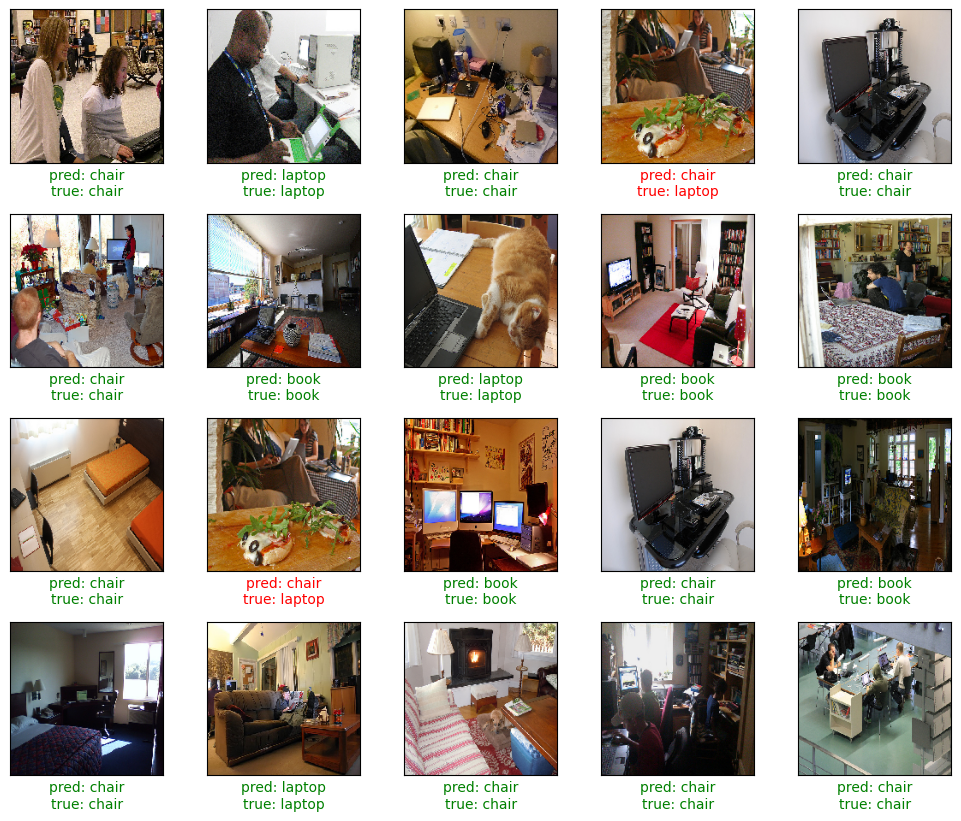

In [12]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
logits = model.predict(X_val[:25], verbose=0)
preds  = tf.nn.softmax(logits, axis=-1).numpy().argmax(axis=1)

plt.figure(figsize=(10, 10))
for i in range(len(preds)):
    plt.subplot(5, 5, i + 1)
    plt.xticks([]); plt.yticks([]); plt.grid(False)
    plt.imshow(X_val[i])
    true_name = class_names[int(y_val[i])]
    pred_name = class_names[int(preds[i])]
    color = "green" if pred_name == true_name else "red"
    plt.xlabel(f"pred: {pred_name}\ntrue: {true_name}", color=color)
plt.tight_layout()
plt.show()


1/1 - 0s - 77ms/step - accuracy: 0.9000 - loss: 0.3578
Test Accuracy: 0.8999999761581421


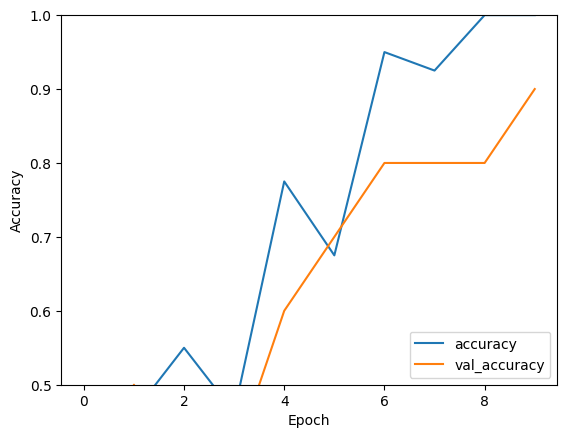

In [13]:
# Evaluate the model
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(X_val,  y_val, verbose=2)

print(f'Test Accuracy: {test_acc}')